# **题目：**

python编程：在20埃×20埃（二维）的box中，创建25个随机分布的原子，输出在周期性边界条件和9埃截断半径下，列出第一个原子的近邻原子列表和对应的距离，并计算LJ势函数硬截断条件下，1-5号原子的总受力

# **解答：**
本人平常matlab使用比较多，代码也应该一股matlab味，大家有python编程更好的建议欢迎直接和我说。每次更新会增加说明。

------12/14日更新------

说明一下编程思路。
首先，目前这个程序可以适用三维计算域，在初始设置的时候给scale变量写成三维就好，不需要其他改动；额外的，scale变量支持原点不为零的计算域。

* 第一步是生成随机原子。这部分代码是用的单老师讲义中的代码。

  值得一提的是，单老师的代码中没考虑周期性边界条件的影响，所生成的原子可能会违背其最小间距的设定。这部分我还没改，如果大家在运行代码观察五个原子总受力的时候出现了非常巨大数值的结果，那应该是这里的问题。随机原子部分留下来一个positions变量，这个变量是跟随scale的维度的，并且考虑了计算域零点的位置。

* 第二步是生成近邻表。近邻表的生成考虑了周期性边界条件

  为了减少输入参数的个数，我将原子数和维度这两个变量在函数内重新计算了，所带来的额外计算量相较于其余的部分应该可以忽略，能节约出来俩输入参数个人觉得是值得的。
  
  输入参数最终选择了原子位置、体系尺寸、截断半径和延申半径四个。
  
  体系尺寸在函数中的作用是用来判断周期性边界条件。当相对位矢的分量的绝对值大于该方向体系尺寸的一半，说明实际影响应当穿透该方向边界，从而进行平移处理。

  为了计算近邻表，首先计算周期性边界条件下的相对距离，之后进行截断判定。这里额外加了一个延申半径是为了匹配讲义中的“goust atoms”，即在本步计算过程中不需计算，但在下次近邻表更新前，可能需要被考虑的原子。在本程序中没有作用，放着或者删掉都好。

  这里有一点纠结的部分，欢迎大家提出宝贵的建议。1、我不知道如何实现动态大小的数组生成，导致我无法在当前步骤完成近邻原子表数组的输出，最后我的方案是使用列表回避这个问题，2。对python的不熟悉导致我提取近邻原子的编号这一步比较不美观。我首先转换为了元组，利用元组再提取编号，最后完成列表输出。3、这个部分可以加快一半的计算时间。我只用计算一半矩阵就ok了，a是b的近邻，那么b肯定也是a的近邻吗，我的程序中重复计算了这个部分，之后可能会优化。

* 第三步是计算受力。这里单独写了一个LJ参数获取的函数，以方便之后加入不同的原子进行计算。

  本程序中使用的是He原子，参数来自于单老师的教材上P340页。单位标准化程序中体现的不好，欢迎大家提出建议。程序中也可能出现单位错误。

  受力的计算就是拿着无量纲形式的LJ计算加速度，然后再乘上单位制换算回来。最后展现的受力不是国际单位制，而是国际单位制的 **m** 换成了 **埃** 。这样子最后的受力结果，小数点没那么多，并且我们记录原子位置的参数单位也是埃。


## 库函数

In [10]:
#先来个库函数
import numpy as np

## 初始参数设置

In [11]:
atom_id = "He"           #原子种类
natom = 25          #原子数目
rcut = 9            #LJ截断半径
neighbor_r = 0      #额外截断半径
scale = [(0,20),(0,20)]

dim = len(scale)
if dim == 2:
    system_size = (scale[0][1]-scale[0][0],scale[1][1]-scale[1][0])
    system_origin = (scale[0][0],scale[1][0])
elif dim ==3:
    system_size = (scale[0][1]-scale[0][0],scale[1][1]-scale[1][0],scale[2][1]-scale[2][0])
    system_origin = (scale[0][0],scale[1][0],scale[2][0])

## 自定义函数

In [12]:
#构建随机位置
#原子数，计算域尺寸
def random_atoms(natom, scale):
    dim = len(scale)
    if dim == 2:
        system_size = (scale[0][1]-scale[0][0],scale[1][1]-scale[1][0])
        system_origin = (scale[0][0],scale[1][0])
    elif dim ==3:
        system_size = (scale[0][1]-scale[0][0],scale[1][1]-scale[1][0],scale[2][1]-scale[2][0])
        system_origin = (scale[0][0],scale[1][0],scale[2][0])
    minDist = 3
    positions = np.zeros((natom,dim))
    positions[0] = np.random.rand(dim)*system_size
    for i in range(1,natom):
        iter, maxIter = 0, 1e5
        while True and iter<maxIter:
            iter += 1
            newpos = np.random.rand(dim)*system_size
            dist = newpos-positions[0:i]
            #12/19更新随机原子生成的周期性边界条件
            for j in range(dim):
                dist[:,j] += (dist[:,j] > system_size[j]/2) * -system_size[j]
                dist[:,j] += (dist[:,j] < -system_size[j]/2) * +system_size[j]
            if np.all( np.linalg.norm(dist,axis=1) > minDist ):
                break
        assert(iter<maxIter)
        positions[i] = newpos
    positions += system_origin
    return positions


#创建近邻表
#输入：坐标，计算域尺寸，截断半径，延申半径
#输出：各原子近邻原子数，各原子近邻原子编号,各原子相对位矢，各原子相对距离
def neighbor_table(positions, system_size, rcut, neighbor_r):
    
    natom = positions.shape[0]
    dim = positions.shape[1]
    
    delt = np.zeros((natom,natom,dim))
    dist = np.zeros([natom,natom])
    neighbor_number = np.zeros(natom, dtype=int)
    neighbor_list = list(range(natom))

    for i in range(natom):
        delt[i,:,:] = positions - positions[i]
        for j in range(dim):
            delt[i,:,j] += (delt[i,:,j] > system_size[j]/2) * -system_size[j]
            delt[i,:,j] += (delt[i,:,j] < -system_size[j]/2) * +system_size[j]
        dist[i] = np.linalg.norm(delt[i,:,:],axis=1)
        dist_bool = dist[i] < rcut+neighbor_r
        neighbor_number[i] = np.sum(dist_bool)-1
        list_tuple = set(np.where(dist_bool)[0])
        list_tuple.remove(i)
        neighbor_list[i] = list(list_tuple)
            
    return([neighbor_number, neighbor_list, delt, dist])

#获取LJ势能参数
#输入：原子类型
#输出：距离，能量，质量，时间
def LJ(atom_id):
    if atom_id == "He":
        [r,e,m] = [2.566,1.411e-22,6.696e-27]
        t = np.sqrt(m*r**2/e)*1e-10
    return[r,e,m,t]


#计算原子受力
#输入：原子类型，各原子近邻原子数，各原子近邻原子编号, 各原子相对位置, 各原子相对距离
#输出：各原子受力
def atom_force(atom_id, neighbor_number,neighbor_list, delt, dist):
    
    natom = delt.shape[0]
    dim = delt.shape[2]
    
    [r,e,m,t] = LJ(atom_id)
    delt = delt / r 
    dist = dist / r 
    force = np.zeros((natom,dim))

    for i in range(natom):
        for j in range(neighbor_number[i]):
            k = neighbor_list[i][j]
            force[i] += 48*(dist[i][k]**-15-0.5*dist[i][k]**-9)*delt[i][k]
    force = force*m*r/t/t
    
    return(force)

## 随机生成+近邻表计算+原子受力

In [13]:
positions = random_atoms(natom, scale)
[neighbor_number,neighbor_list,delt,dist] = neighbor_table(positions, system_size, rcut, neighbor_r)
force = atom_force(atom_id, neighbor_number, neighbor_list, delt, dist)
print(positions)

[[ 8.21127903  0.63361234]
 [ 3.68466733  1.08392284]
 [19.89126     5.61163944]
 [ 8.01969482  5.52697598]
 [ 7.43900713 16.32160629]
 [14.89667399  9.35786304]
 [13.59258651  3.46585963]
 [14.34507311 13.80946618]
 [ 4.61233016  4.39255092]
 [19.46221085  0.75240526]
 [14.17583383 18.44537848]
 [11.3507294   7.17107252]
 [17.04095146 16.01362955]
 [ 1.09990337 16.57854203]
 [ 1.65512744  8.71055442]
 [18.9916525  12.31949048]
 [ 5.57451227  9.19317281]
 [11.43480082 12.77663611]
 [ 4.43718523 17.44628035]
 [ 4.88801705 14.07995509]
 [ 7.29694325 12.00597401]
 [11.34501716 17.2828486 ]
 [16.872429    6.85268688]
 [11.23765889  1.30602791]
 [16.68952757  2.08417107]]


[1, 3, 4, 6, 8, 9, 10, 11, 13, 16, 17, 18, 19, 20, 21, 23, 24]


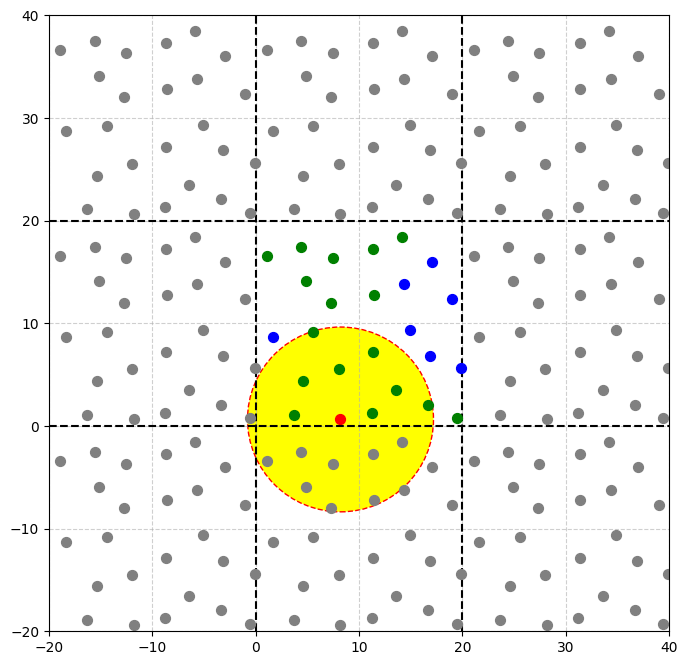

In [14]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
print(neighbor_list[0])

def plot_positions(positions):
    """
    Plot the positions of the atoms in the box.
    
    Parameters
    positions : list of tuples
        The positions of the atoms. Each tuple contains the coordinates
        of the atoms.
    """
    # Create a figure and axes with specified figure size
    fig, box = plt.subplots(figsize=(8, 8))
    plt.ylim([-20, 40])  # Setting the y-axis limits for the expanded box
    plt.xlim([-20, 40])  # Setting the x-axis limits for the expanded box
    plt.axhline(0, color='black', linestyle='--')
    plt.axhline(20, color='black', linestyle='--')
    plt.axvline(0, color='black', linestyle='--')
    plt.axvline(20, color='black', linestyle='--')
    # Set grid properties
    box.grid(True, linestyle='--', alpha=0.6)  # 添加虚线网格
    
    # Plot the players and circles
    for i in range(3):  # Repeat 3 times to create 3x3 box
        for j in range(3):
            for k, (x, y) in enumerate(positions):
                # Offset the x and y coordinates to replicate the points
                new_x = x + i * 20 - 20  # Adjusted offset for the new x-axis limits
                new_y = y + j * 20 - 20  # Adjusted offset for the new y-axis limits
                
                # Plot the players
                if (i == j == 1): 
                    color = 'blue'
                    for nerbor in neighbor_list[0]:
                        if nerbor == k: color = 'green'
                    if (k == 0): 
                        color = 'red' 
                else: color = 'grey'
                zorder = 1 if k == 0 and i == 1 and j == 1 else 2  # Set zorder to 1 for the circle, 2 for other points
                box.scatter(new_x, new_y, s=50, c=color, zorder=zorder)
                
                if k == 0 and i == 1 and j == 1:
                    # Draw a circle with radius 9 centered at the first point
                    circle = Circle((new_x, new_y), radius=9, edgecolor='red', facecolor='yellow', linestyle='--', zorder= 0)
                    box.add_patch(circle)

    plt.show()  # 显示图表
plot_positions(positions)

In [15]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def plot_positions(positions):
    """
    在盒子中绘制原子的位置。

    Parameters
    ----------
    positions : list of tuples
        原子的位置。每个元组包含原子的坐标。

    Returns
    -------
    None
    """
    # 创建指定大小的图和坐标轴
    fig, box = plt.subplots(figsize=(6, 6))
    plt.ylim([0, 20])  # 设置y轴的限制
    plt.xlim([0, 20])  # 设置x轴的限制
    # 设置网格属性
    box.grid(True, linestyle='--', alpha=0.6)  # 添加虚线网格
    
    # 遍历创建3x3的盒子
    for i in range(3):
        for j in range(3):
            for k, (x, y) in enumerate(positions):
                # 偏移x和y坐标以复制点
                new_x = x + i * 20 - 20  # 调整新x轴限制的偏移
                new_y = y + j * 20 - 20  # 调整新y轴限制的偏移
                
                # 绘制原子
                if (i == j == 1):
                    color = 'blue'
                    for neighbor in neighbor_list[0]:
                        if neighbor == k:
                            color = 'green'
                    if (k == 0):
                        color = 'red'
                else:
                    color = 'grey'
                zorder = 1 if k == 0 and i == 1 and j == 1 else 2  # 设置zorder为1表示圆形，为2表示其他点
                box.scatter(new_x, new_y, s=100, c=color, zorder=zorder)
                
                if k == 0:
                    # 在第一个点处绘制半径为9的圆形
                    circle = Circle((new_x, new_y), radius=9, edgecolor='red', facecolor='yellow', linestyle='--', zorder=0)
                    box.add_patch(circle)
                    circle.set_alpha(0.5)  # 设置圆形的透明度

    plt.show()  # 显示图表


In [16]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def plot_boxes(positions):
    """
    在两个盒子中绘制原子的位置。

    Parameters
    ----------
    positions : list of tuples
        原子的位置。每个元组包含原子的坐标。

    Returns
    -------
    None
    """
    # 创建第一个图表
    fig, box1 = plt.subplots(figsize=(8, 8))
    box1.set_ylim([0, 20])  # 设置y轴的限制
    box1.set_xlim([0, 20])  # 设置x轴的限制
    box1.grid(True, linestyle='--', alpha=0.6)  # 添加虚线网格
    
    # 创建第二个图表，box2为九宫格
    fig, box2 = plt.subplots(figsize=(8, 8))
    box2.set_ylim([-20, 40])  # 设置y轴的限制
    box2.set_xlim([-20, 40])  # 设置x轴的限制
    box2.grid(True, linestyle='--', alpha=0.6)  # 添加虚线网格
    # 在box2上绘制虚线
    box2.axhline(0, color='black', linestyle='--')
    box2.axhline(20, color='black', linestyle='--')
    box2.axvline(0, color='black', linestyle='--')
    box2.axvline(20, color='black', linestyle='--')
    
    for box in [box1, box2]:
        box.set_xlabel('X (Å)')  # 设置x轴标签
        box.set_ylabel('Y (Å)')  # 设置y轴标签
        # 遍历创建3x3的盒子
        for i in range(3):
            for j in range(3):
                for k, (x, y) in enumerate(positions):
                    # 偏移x和y坐标以复制点
                    new_x = x + i * 20 - 20  # 调整新x轴限制的偏移
                    new_y = y + j * 20 - 20  # 调整新y轴限制的偏移
                    
                    # 绘制原子，如果在原始的盒子中，绘制蓝色
                    if (i == j == 1):
                        color = 'blue'
                        # 遍历近邻列表，绘制绿色
                        for neighbor in neighbor_list[0]:
                            if neighbor == k:
                                color = 'green'
                        # 将第0个原子设置红色
                        if (k == 0):
                            color = 'red'
                    else:
                        color = 'grey'
                    zorder = 1 if k == 0 and i == 1 and j == 1 else 2  # 设置zorder为1表示圆形，为2表示其他点
                    box.scatter(new_x, new_y, s=50, c=color, zorder=zorder)
                    
                    if k == 0:
                        # 在第一个点处绘制半径为9的圆形
                        circle = Circle((new_x, new_y), radius=9, edgecolor='red', facecolor='yellow', linestyle='--', zorder=0)
                        box1.add_patch(circle)
                        circle.set_alpha(0.4)  # 设置圆形的透明度
                        if i == 1 and j == 1:
                            circle = Circle((new_x, new_y), radius=9, edgecolor='red', facecolor='yellow', linestyle='--', zorder=0)
                            box2.add_patch(circle)
                            circle.set_alpha(0.4)  

    # 显示图表
    plt.show()

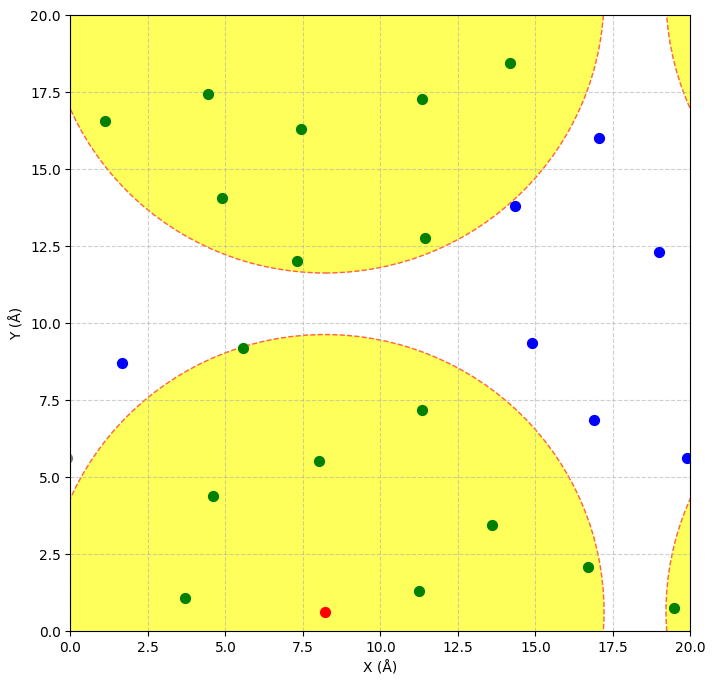

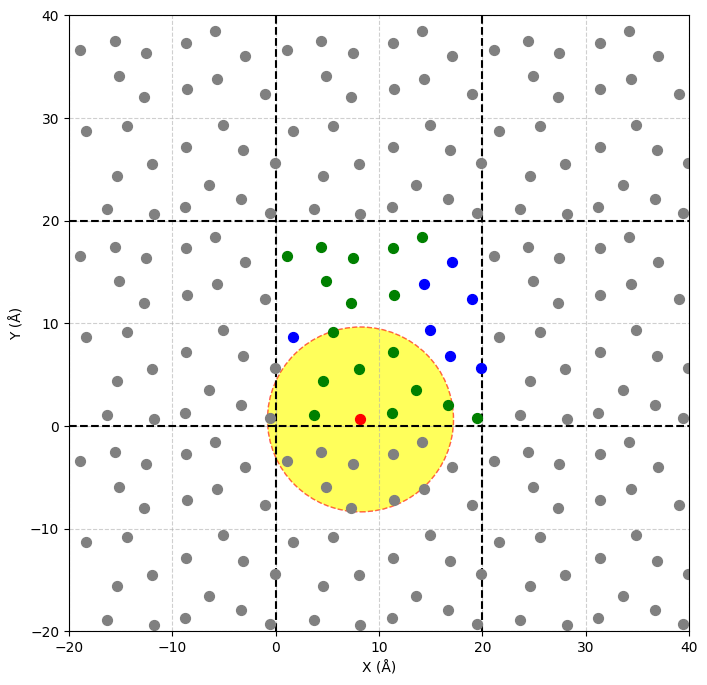

In [17]:
plot_boxes(positions)

## 计算结果

In [21]:
print(positions)
print('第一个原子的近邻原子为：')
print(neighbor_list[0])
print(neighbor_list)

print('第一个原子与近邻原子距离为：')
for i in range(len(neighbor_list[1])):
    print(dist[1][neighbor_list[1][i]])

[[ 8.21127903  0.63361234]
 [ 3.68466733  1.08392284]
 [19.89126     5.61163944]
 [ 8.01969482  5.52697598]
 [ 7.43900713 16.32160629]
 [14.89667399  9.35786304]
 [13.59258651  3.46585963]
 [14.34507311 13.80946618]
 [ 4.61233016  4.39255092]
 [19.46221085  0.75240526]
 [14.17583383 18.44537848]
 [11.3507294   7.17107252]
 [17.04095146 16.01362955]
 [ 1.09990337 16.57854203]
 [ 1.65512744  8.71055442]
 [18.9916525  12.31949048]
 [ 5.57451227  9.19317281]
 [11.43480082 12.77663611]
 [ 4.43718523 17.44628035]
 [ 4.88801705 14.07995509]
 [ 7.29694325 12.00597401]
 [11.34501716 17.2828486 ]
 [16.872429    6.85268688]
 [11.23765889  1.30602791]
 [16.68952757  2.08417107]]
第一个原子的近邻原子为：
[1, 3, 4, 6, 8, 9, 10, 11, 13, 16, 17, 18, 19, 20, 21, 23, 24]
[[1, 3, 4, 6, 8, 9, 10, 11, 13, 16, 17, 18, 19, 20, 21, 23, 24], [0, 2, 3, 4, 8, 9, 12, 13, 14, 16, 18, 19, 21, 22, 23, 24], [1, 3, 5, 6, 8, 9, 11, 14, 15, 16, 22, 24], [0, 1, 2, 5, 6, 8, 11, 14, 16, 17, 18, 20, 21, 22, 23], [0, 1, 7, 8, 10, 13, 16

In [19]:
ans = np.zeros(dim)
for i in range(5):
    ans += force[i]
    
print('前五个粒子受力总和为：(kg*A/s^2)')
print(ans)

前五个粒子受力总和为：(kg*A/s^2)
[ 0.00998715 -0.00983353]


原子可视化

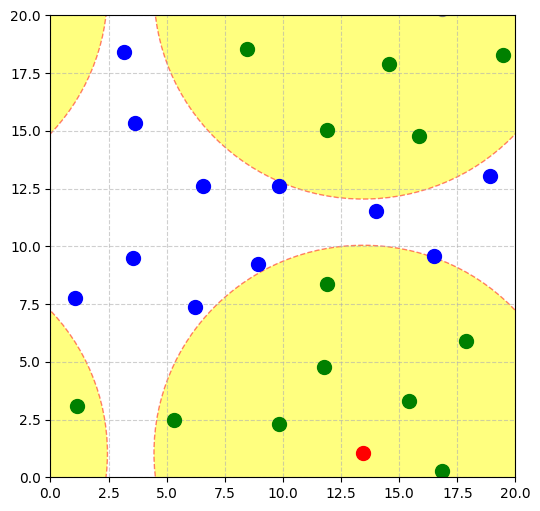

In [16]:
plot_positions(positions)